In [178]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import scipy

from utils.depth_camera import DepthCamera

In [179]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [180]:
data_dir = "data/raw_data"
experiment = "exp_7"
trial = "trial_1"
subject = "subject-1"
sequence = 3

In [181]:
motion_dir = os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "motion")

In [182]:
accel_df = pd.read_csv(os.path.join(motion_dir, "accelerometer"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyroscope"))

accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

gravity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

raw_accel_df = imu_df[["timestamp", "xa", "ya", "za"]].copy()

In [ ]:
# Low pass filter
alpha = 0.1
gravity = [0, 0, 0]

for i in tqdm.trange(imu_df.shape[0]):
    for j in range(3):
        gravity[j] = alpha * gravity[j] + (1 - alpha) * imu_df.iloc[i, 1 + j]
        imu_df.iloc[i, 1 + j] = imu_df.iloc[i, 1 + j] - gravity[j]
    
    gravity_df = pd.concat([gravity_df, pd.DataFrame({"timestamp": [imu_df.iloc[i, 0]], "x": [gravity[0]], "y": [gravity[1]], "z": [gravity[2]]})], ignore_index=True)

In [183]:
accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=2000).mean()
imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

# imu_df.dropna(inplace=True)
# imu_df.reset_index(drop=True, inplace=True)

# accel_mavg.loc[:, "r"] = accel_mavg.apply(lambda row: np.linalg.norm(row[["xa", "ya", "za"]]), axis=1)

In [11]:
gravity_df.loc[:, "r"] = gravity_df.apply(lambda row: np.linalg.norm(row[["x", "y", "z"]]), axis=1)

In [30]:
gravity_df_all = gravity_df.copy()
gravity_df_all.drop(["x", "y", "z"], axis=1, inplace=True)

In [43]:
gravity_df_all.loc[:, "0.8"] = gravity_df.loc[:, "r"]

<AxesSubplot:xlabel='timestamp'>

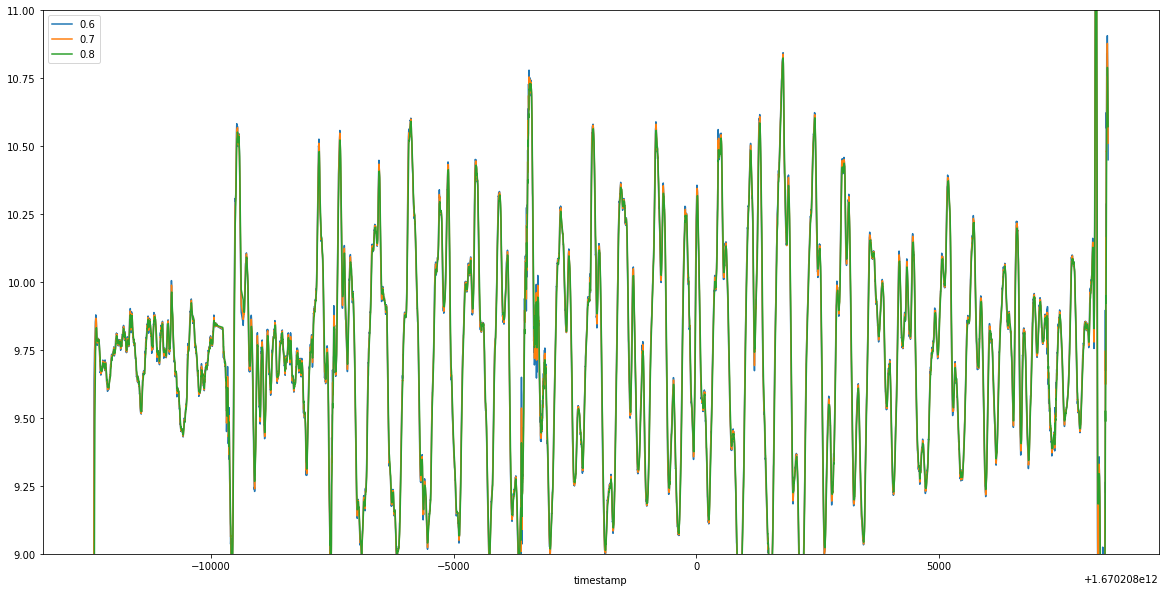

In [44]:
gravity_df_all.plot(x="timestamp", ylim=(9, 11), figsize=(20, 10))

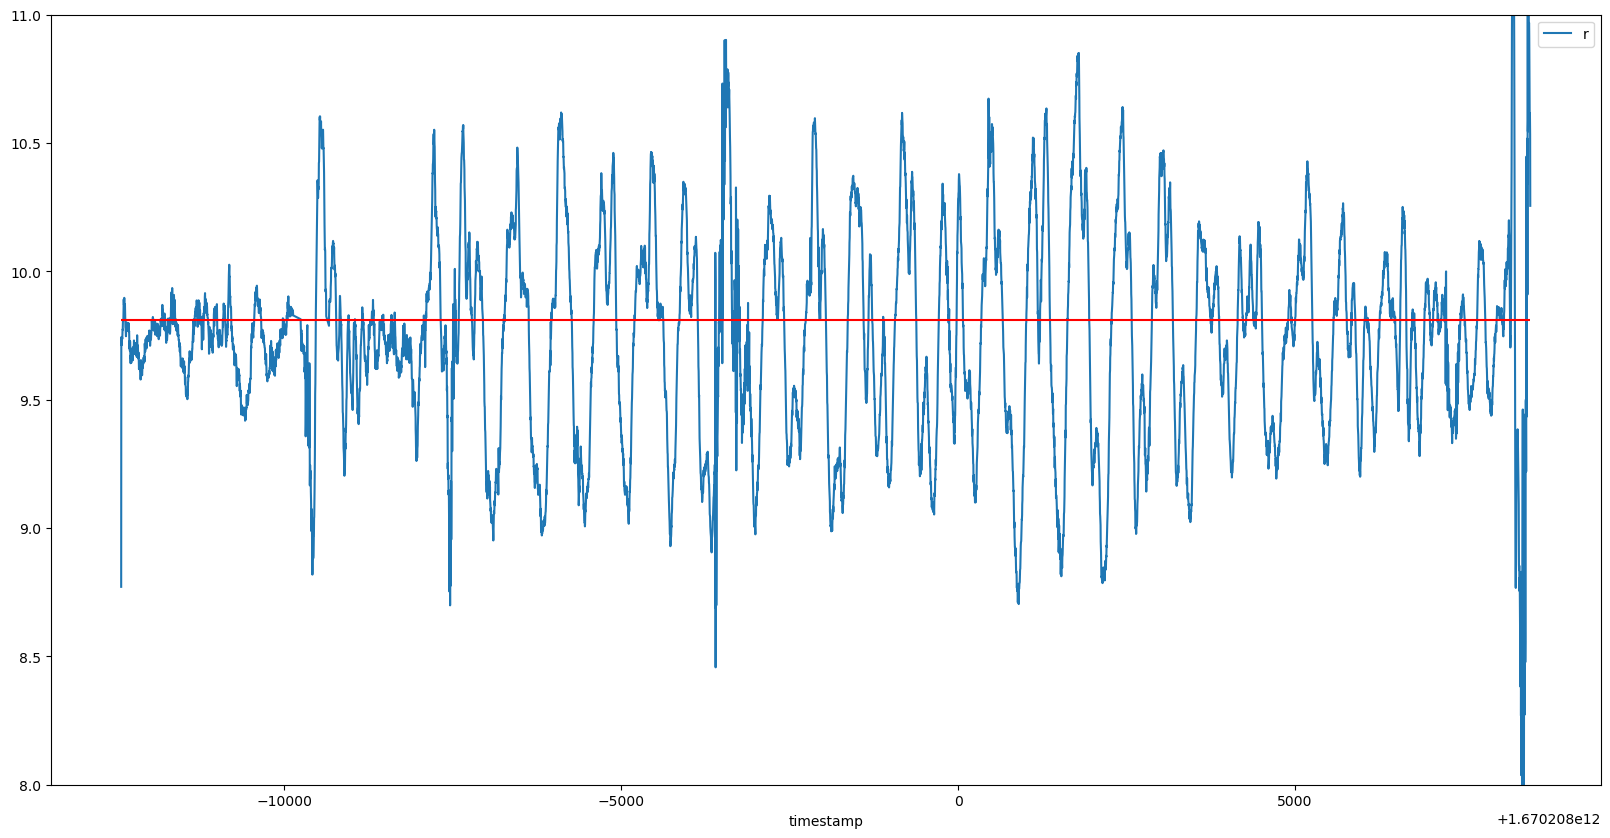

In [12]:
plot = gravity_df.plot(x="timestamp", y="r", ylim=(8, 11), figsize=(20, 10))
plot.hlines(9.81, gravity_df.timestamp.values[0], gravity_df.timestamp.values[-1], colors="red")

Text(0, 0.5, 'Acceleration (m/s^2)')

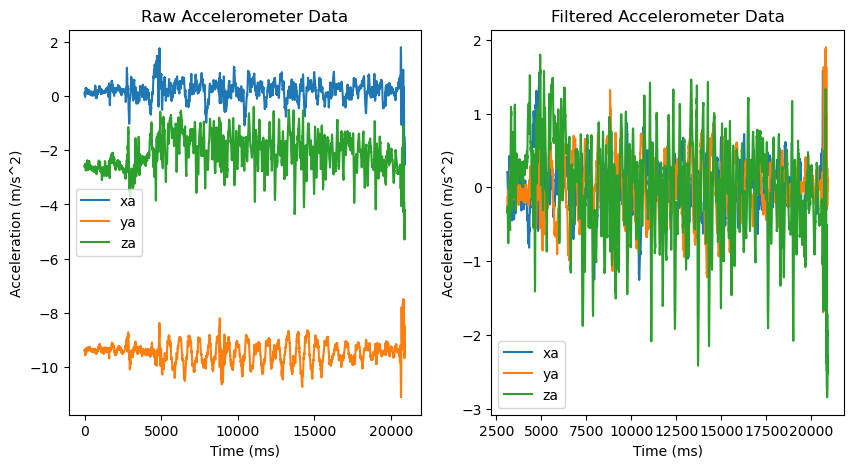

In [137]:
filtered_accel_df = imu_df[["timestamp", "xa", "ya", "za"]].copy()

filtered_accel_df.loc[:, "timestamp"] = filtered_accel_df.timestamp.values - filtered_accel_df.timestamp.values[0]
raw_accel_df.loc[:, "timestamp"] = raw_accel_df.timestamp.values - raw_accel_df.timestamp.values[0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

raw_accel_df.set_index("timestamp").loc[:, ["xa", "ya", "za"]].plot(ax=axes[0])
filtered_accel_df.set_index("timestamp").loc[:, ["xa", "ya", "za"]].plot(ax=axes[1])

axes[0].set_title("Raw Accelerometer Data")
axes[1].set_title("Filtered Accelerometer Data")

axes[0].set_xlabel("Time (ms)")
axes[1].set_xlabel("Time (ms)")

axes[0].set_ylabel("Acceleration (m/s^2)")
axes[1].set_ylabel("Acceleration (m/s^2)")

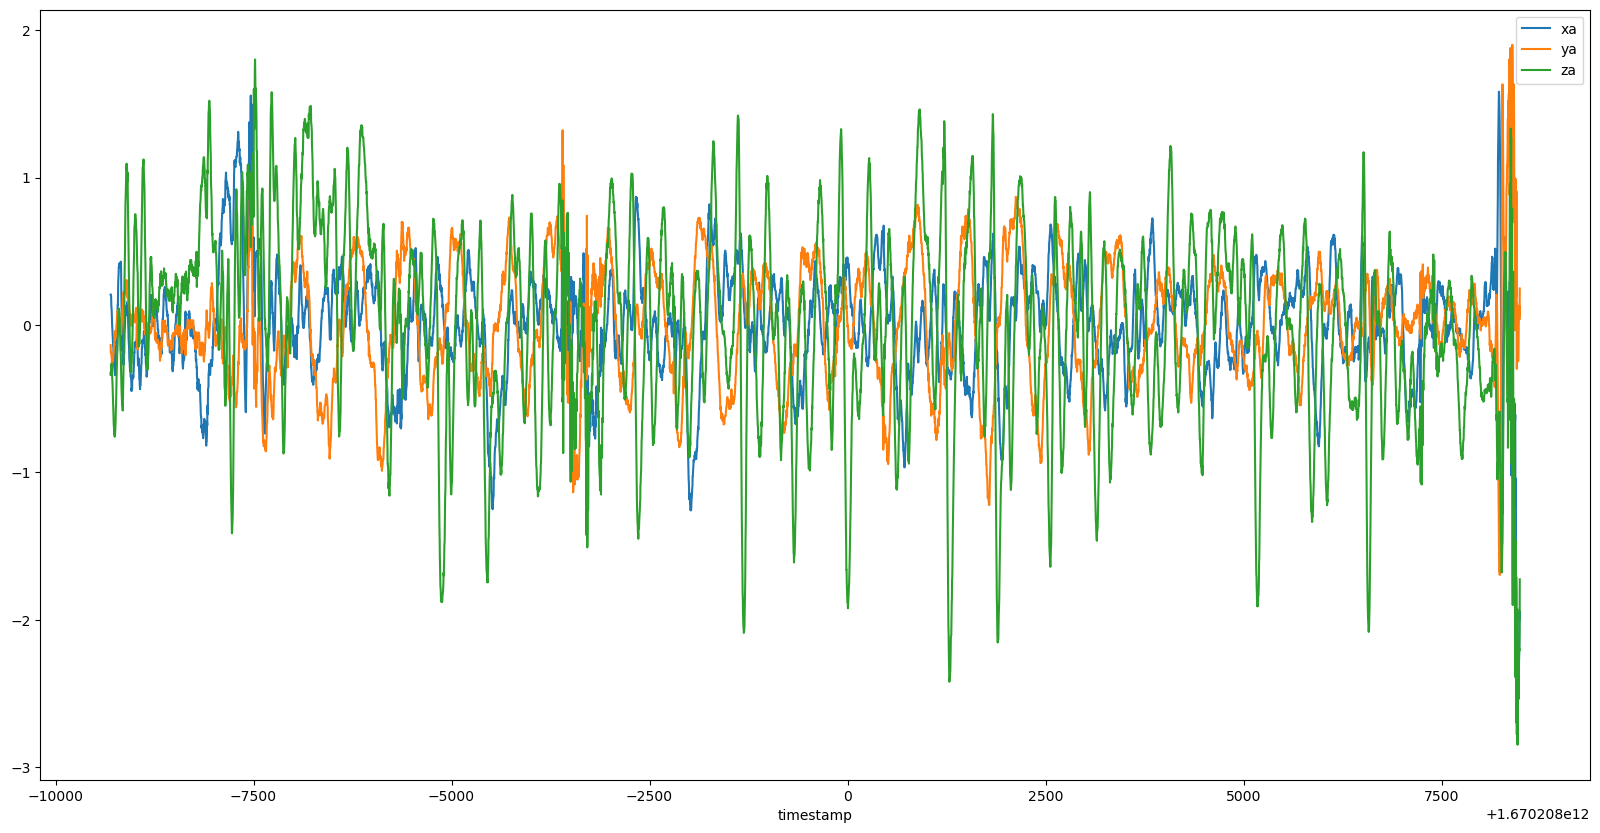

In [141]:
plot = imu_df.plot(x="timestamp", y=["xa", "ya", "za"], figsize=(20, 10))
# plot.hlines(-9.81, imu_df.timestamp.values[0], imu_df.timestamp.values[-1], colors="red")

In [123]:
raw_accel_df.loc[:, "r"] = raw_accel_df.apply(lambda row: max(0, np.linalg.norm(row[["xa", "ya", "za"]]) - 9.81), axis=1)

In [126]:
raw_accel_df.loc[:, "dt"] = np.concatenate([[0], (raw_accel_df.timestamp.values[1:] - raw_accel_df.timestamp.values[:-1]) / 1000])

In [127]:
raw_accel_df

,timestamp,xa,ya,za,r,dt
0,1.670208e+12,0.062030,-9.400411,-2.570001,0.000000,0.000
1,1.670208e+12,0.081685,-9.419782,-2.569731,0.000000,0.001
2,1.670208e+12,0.093232,-9.389303,-2.628013,0.000000,0.001
3,1.670208e+12,0.092560,-9.389657,-2.598429,0.000000,0.001
4,1.670208e+12,0.143216,-9.348952,-2.625650,0.000000,0.001
...,...,...,...,...,...,...
8367,1.670208e+12,-2.071559,-9.266627,-4.738589,0.802067,0.004
8368,1.670208e+12,-2.013505,-9.256516,-4.667437,0.750410,0.002
8369,1.670208e+12,-1.845334,-9.351890,-4.683551,0.810675,0.002
8370,1.670208e+12,-1.768050,-9.312299,-4.571747,0.713582,0.003


In [128]:
velocity = 0
distance = 0

for i in tqdm.trange(len(raw_accel_df)):
    v = raw_accel_df.iloc[i].values
    dt = v[5]
    distance = distance + (velocity * dt) + (0.5 * v[4] * dt * dt)
    velocity = velocity + v[1] * dt

100%|██████████| 8372/8372 [00:00<00:00, 15623.99it/s]


In [129]:
distance

45.33573457637663

In [184]:
# remove first second's data (as it stabilizes the gravity)
# imu_df = imu_df.iloc[400:]
imu_df.dropna(inplace=True)
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='timestamp'>

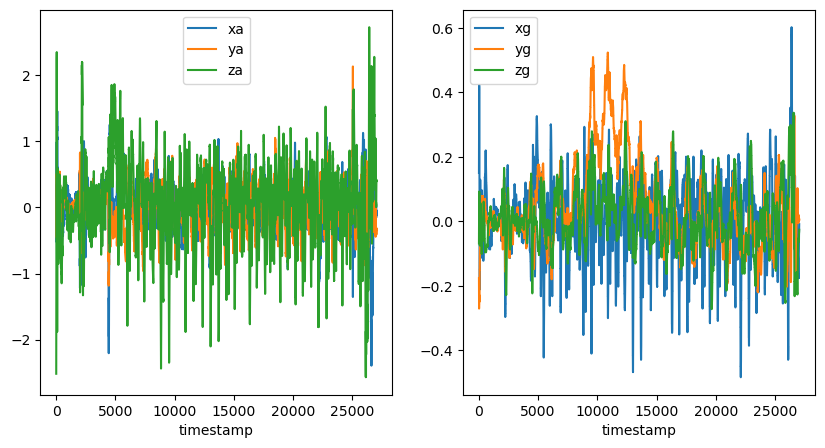

In [185]:
plot_df = imu_df.copy()
plot_df.loc[:, "timestamp"] = plot_df.timestamp.values - plot_df.timestamp.values[0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

plot_df.set_index("timestamp").loc[:, ["xa", "ya", "za"]].plot(ax=axes[0])
plot_df.set_index("timestamp").loc[:, ["xg", "yg", "zg"]].plot(ax=axes[1])

In [186]:
# Fill 0 for displacement and angles
imu_df.loc[:, "dx"] = np.zeros(len(imu_df))
imu_df.loc[:, "dy"] = np.zeros(len(imu_df))
imu_df.loc[:, "dz"] = np.zeros(len(imu_df))
imu_df.loc[:, "rx"] = np.zeros(len(imu_df))
imu_df.loc[:, "ry"] = np.zeros(len(imu_df))
imu_df.loc[:, "rz"] = np.zeros(len(imu_df))

In [187]:
velocity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

In [188]:
# displacement = [0, 0, 0]
velocity = [0, 0, 0]
angle = [0, 0, 0]

for i in tqdm.trange(len(imu_df)):
    imu = imu_df.iloc[i].values
    dt = imu[7]
    for j, axis in enumerate(["x", "y", "z"]):
        # velocity[j] = velocity[j] + imu[j + 1] * dt
        # Update the displacement
        # displacement[j] = displacement[j] + (velocity[j] * dt) + (0.5 * acceleration[j + 1] * dt * dt)
        angle[j] += imu[j + 4] * dt

        imu_df.iloc[i, 8 + j] = (velocity[j] * dt) + (0.5 * imu[j + 1] * dt * dt)
        imu_df.iloc[i, 11 + j] = np.degrees(angle[j])

        velocity[j] = velocity[j] + imu[j + 1] * dt
        
    velocity_df = pd.concat([velocity_df, pd.DataFrame([[imu[0], velocity[0], velocity[1], velocity[2]]], columns=["timestamp", "x", "y", "z"])])

100%|██████████| 10907/10907 [00:07<00:00, 1413.84it/s]


In [189]:
velocity_df.loc[:, "r"] = velocity_df.apply(lambda row: np.linalg.norm(row[["x", "y", "z"]]), axis=1)

<AxesSubplot:xlabel='timestamp'>

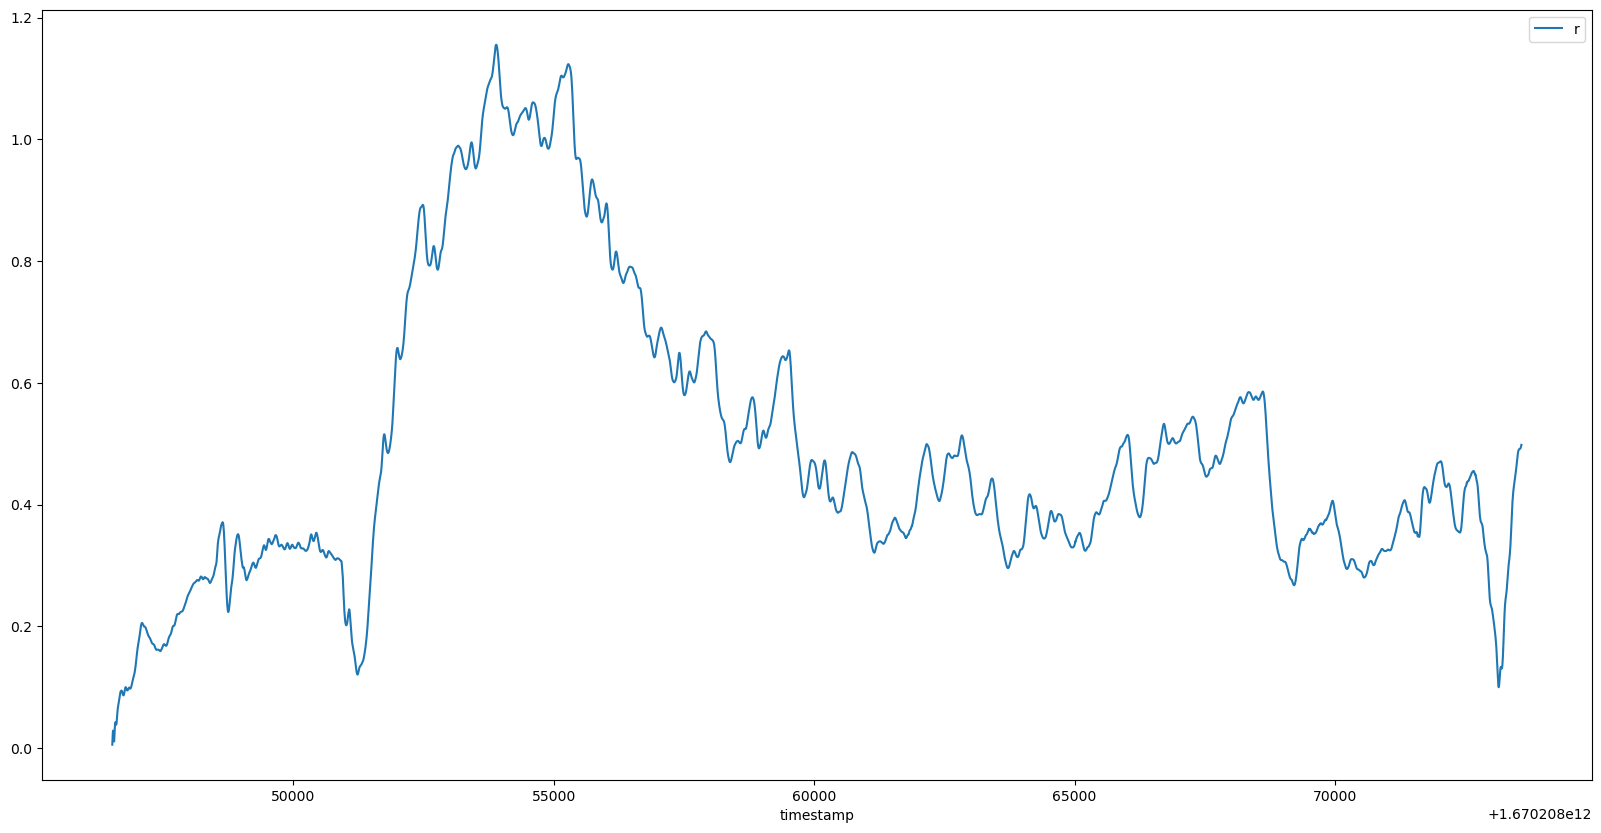

In [190]:
velocity_df.plot(x="timestamp", y="r", figsize=(20, 10))

In [93]:
duration = imu_df.timestamp.values[-1] - imu_df.timestamp.values[0]
print("Duration: {} ms".format(duration))
print("Distance: {} m".format(duration * 0.03 / 1000))

Duration: 18933.0 ms
Distance: 0.56799 m


In [191]:
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [192]:
for i in tqdm.tqdm(range(1, len(imu_df))):
    c = imu_df.iloc[i].values           # current readings
    p = imu_df.iloc[i - 1].values       # previous readings

    R = helpers.rotate_transformation_matrix(np.identity(4), p[11], p[12], p[13])

    d = np.dot(R, np.array([c[8], c[9], c[10], 1]))

    imu_df.iloc[i, 14] = p[14] + d[0]
    imu_df.iloc[i, 15] = p[15] + d[1]
    imu_df.iloc[i, 16] = p[16] + d[2]

100%|██████████| 10906/10906 [00:02<00:00, 3802.14it/s]


In [193]:
xyz = imu_df.loc[:, ["x", "y", "z"]].values

pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

PointCloud with 10907 points.

In [194]:
np.linalg.norm(xyz[-1])

7.541114784976693

In [195]:
open3d.visualization.draw_geometries([pcd])

In [196]:
file_name = f"{experiment}__{trial}__{subject}__{sequence:02d}"

pose_file = os.path.join("data/trajectories/groundtruth", experiment, f"{file_name}.pose.npz")

trajectory_t = np.load(pose_file)["trajectory_t"]

In [197]:
pcd_gt = helpers.make_pcd(trajectory_t[:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])

PointCloud with 645 points.

In [198]:
open3d.visualization.draw_geometries([pcd_gt, pcd])

In [65]:
np.linalg.norm(trajectory_t[-1, :3, 3])

9.345717843359145

Experiment to check integration with simulated data

In [78]:
imu = [[2] for _ in range(2000)] + [[0] for _ in range(3000)] + [[-2] for _ in range(2000)]
timestamps = [[i] for i in range(7000)]

data = np.concatenate([timestamps, imu], axis=1)

accel_df = pd.DataFrame(data, columns=["timestamp", "x"])

In [79]:
# accel_df.loc[:, "dt"] = (accel_df.timestamp.values - accel_df.timestamp.values[0]) / 1000
accel_df.loc[:, "dt"] = np.concatenate([[0], (accel_df.timestamp.values[1:] - accel_df.timestamp.values[:-1]) / 1000])
# remove first row
accel_df = accel_df.iloc[1:]

In [80]:
accel_df.loc[:, "dx"] = np.zeros(len(accel_df))

In [76]:
accel_df.values[10]

array([1.2e+01, 2.0e+00, 1.0e-03])

In [84]:
velocity = 0
distance = 0

for i in tqdm.trange(len(accel_df)):
    v = accel_df.iloc[i].values
    dt = v[2]
    distance = distance + (velocity * dt) + (0.5 * v[1] * dt * dt)
    accel_df.iloc[i, 3] = distance
    velocity = velocity + v[1] * dt

100%|██████████| 6999/6999 [00:01<00:00, 5301.51it/s]


<AxesSubplot:xlabel='timestamp'>

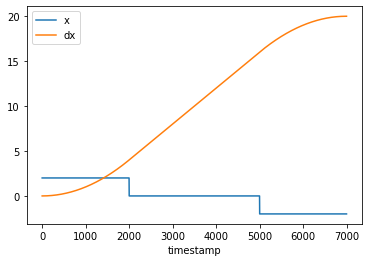

In [85]:
accel_df.set_index("timestamp").loc[:, ["x", "dx"]].plot()

In [ ]:
d = 0.5 * 2 * 4 + 4 * 3 + 0.5 * 4 * 2
print(f"Total distance: {d}")

Linear acceleration from Android API

In [105]:
accel_df = pd.read_csv("data/android/1673931013121/acceleration.csv", names=["timestamp", "x", "y", "z"])
gyro_df = pd.read_csv("data/android/1673931013121/gyroscope.csv", names=["timestamp", "x", "y", "z"])

In [106]:
accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

<AxesSubplot:xlabel='timestamp'>

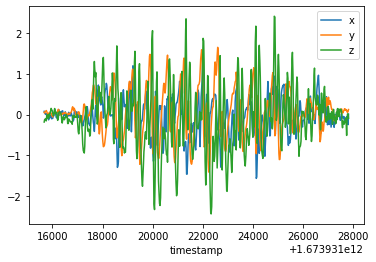

In [107]:
accel_df.loc[125:, ["timestamp", "x", "y", "z"]].set_index("timestamp").plot()

In [108]:
accel_df = accel_df.iloc[125:]

accel_df.loc[:, "gyro_t"] = accel_df.apply(lambda x: nearest(gyro_df.timestamp.values, x.timestamp), axis=1)

imu_df = pd.merge(
    accel_df.loc[:, ["gyro_t", "x", "y", "z"]],
    gyro_df.loc[:, ["timestamp", "x", "y", "z"]],
    left_on="gyro_t",
    right_on="timestamp",
    suffixes=("a", "g")
)

imu_df.drop("gyro_t", axis=1, inplace=True)
imu_df = imu_df.loc[:, ["timestamp", "xa", "ya", "za", "xg", "yg", "zg"]]

In [109]:
# remove first second's data (as it stabilizes the gravity)
# imu_df = imu_df.iloc[400:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

In [110]:
# Fill 0 for displacement and angles
imu_df.loc[:, "dx"] = np.zeros(len(imu_df))
imu_df.loc[:, "dy"] = np.zeros(len(imu_df))
imu_df.loc[:, "dz"] = np.zeros(len(imu_df))
imu_df.loc[:, "rx"] = np.zeros(len(imu_df))
imu_df.loc[:, "ry"] = np.zeros(len(imu_df))
imu_df.loc[:, "rz"] = np.zeros(len(imu_df))

In [111]:
# displacement = [0, 0, 0]
velocity = [0, 0, 0]
angle = [0, 0, 0]

for i in range(len(imu_df)):
    imu = imu_df.iloc[i].values
    dt = imu[7]
    for j, axis in enumerate(["x", "y", "z"]):
        # velocity[j] = velocity[j] + imu[j + 1] * dt
        # Update the displacement
        # displacement[j] = displacement[j] + (velocity[j] * dt) + (0.5 * acceleration[j + 1] * dt * dt)
        angle[j] += imu[j + 4] * dt

        imu_df.iloc[i, 8 + j] = (velocity[j] * dt) + (0.5 * imu[j + 1] * dt * dt)
        # imu_df.iloc[i, 11 + j] = imu[j + 4] * dt
        imu_df.iloc[i, 11 + j] = np.degrees(angle[j])

        velocity[j] = velocity[j] + imu[j + 1] * dt

In [112]:
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [113]:
for i in range(1, len(imu_df)):
    c = imu_df.iloc[i].values           # current readings
    p = imu_df.iloc[i - 1].values       # previous readings

    R = helpers.rotate_transformation_matrix(np.identity(4), p[11], p[12], p[13])

    d = np.dot(R, np.array([c[8], c[9], c[10], 1]))

    imu_df.iloc[i, 14] = p[14] + d[0]
    imu_df.iloc[i, 15] = p[15] + d[1]
    imu_df.iloc[i, 16] = p[16] + d[2]

In [114]:
xyz = imu_df.loc[:, ["x", "y", "z"]].values

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(xyz)

open3d.visualization.draw_geometries([pcd])

In [115]:
np.linalg.norm(xyz[-1])

8.289169564567784